In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from pandas_profiling import ProfileReport
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
#import warnings; 
#warnings.simplefilter('ignore')
import seaborn as sns
from scipy import stats
import numpy as np

%matplotlib inline
plt.rcParams.update({'font.size': 16, 'figure.figsize': (16,6)})



In [2]:
import random

filename = 'data/training_set_VU_DM.csv'
p = 0.1  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)

#df = pd.read_csv(filename, nrows=1000)
df['date_time'] = pd.to_datetime(df['date_time'])

df_test = pd.read_csv('data/test_set_VU_DM.csv', header=0, skiprows=lambda i: i>0 and random.random() > p)
df_test['date_time'] = pd.to_datetime(df_test['date_time'])

In [3]:
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

# Filter outliers

## Filter price_usd (added to preproc)

<AxesSubplot:>

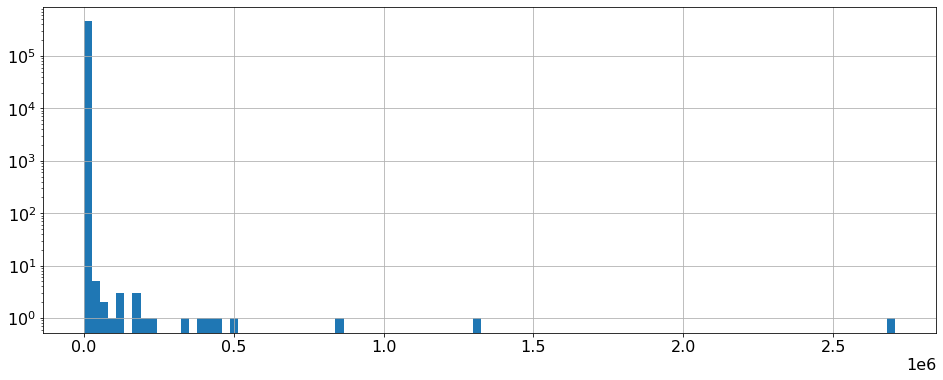

In [4]:
# filter outlieing prices per prop_id
# still some outliers left
mean = df.groupby(['prop_id'])['price_usd'].transform('mean')    
std = df.groupby(['prop_id'])['price_usd'].transform('std')

df = df[abs((df['price_usd'] - mean) / std) < 2]
df['price_usd'].hist(bins=100, log=True)

<AxesSubplot:>

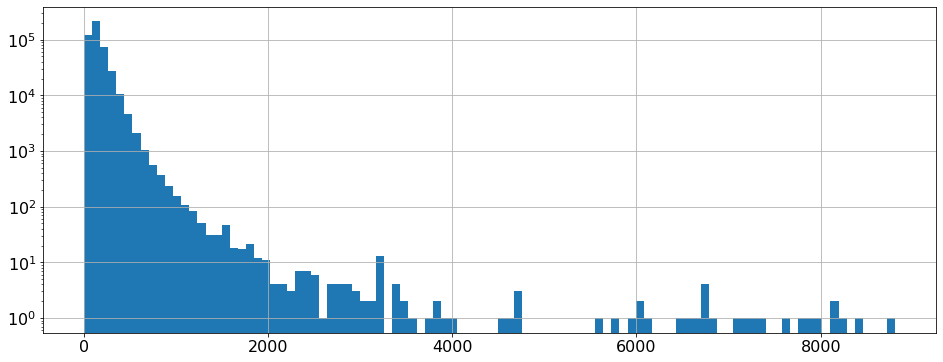

In [5]:
# filter outlieing prices overall
# the limit is around 8.000 USD, above that there is only 1 entry per price bracket -> mistake
# drop rows with prices with std > 2
df = df[stats.zscore(df['price_usd']) < 2]
df['price_usd'].hist(bins=100, log=True)

## Order of the price per srch_id, srch_destination_id, prop_id

price within a group regardless random\not. works for train and subm

In [ ]:
df.sort_values(['srch_id', 'price_usd'], inplace=True)
df['index_per_srch_id'] = df.groupby(['srch_id']).cumcount()
df.sort_index(inplace=True)

In [7]:
df.sort_values(['srch_destination_id', 'price_usd'], inplace=True)
df['index_per_srch_destination_id'] = df.groupby(['srch_destination_id']).cumcount()
df.sort_index(inplace=True)

In [8]:
df.sort_values(['prop_id', 'price_usd'], inplace=True)
df['index_per_prop_id'] = df.groupby(['prop_id']).cumcount()
df.sort_index(inplace=True)

## Calculate date of trip (added to preproc)
from: date_time + srch_booking_window\
until: date_time + srch_booking_window + srch_length_of_stay

In [9]:
df['date'] = df['date_time'].dt.floor('D')
df['days_until_trip'] = pd.to_timedelta(df['srch_booking_window'], unit='D')

df['start_date'] = df['date'] + df['days_until_trip']
df['end_date'] = df['date'] + df['days_until_trip'] + pd.to_timedelta(df['srch_length_of_stay'], unit='D')

check that friday-sunday works

## Count holidays (work free day) during the trip (added to preproc)

In [10]:
cal = calendar()
holidays = cal.holidays(start=min(df['start_date']), end=max(df['end_date']))

df['holiday'] = 0
for holiday in holidays:
    df['holiday'] += (df['start_date'] <= holiday) & (df['end_date'] >= holiday)

make one-hot for most important holidays

add holidays for the booking days

add some number of days before and after. weight them

## Try to separate business trips from holidays (added to preproc)

sign for worktrip:\
srch_children_count = 0\
srch_adults_count = 1\
srch_saturday_night_bool = False\
srch_length_of_stay < avg\
orig_destination_distance < avg\
srch_booking_window < avg

In [11]:
df['business_trip'] = False
df.loc[(df['srch_children_count'] == 0) & (df['srch_adults_count'] == 1) & 
       (~df['srch_saturday_night_bool']) & (df['srch_length_of_stay'] <= 5), 'business_trip'] = True

## Some Hotels use price/day, other use price/trip (added to preproc)
Try to find what price hotels showed and create features price_per_day and price_per_trip

In [12]:
# calculate difference between gross_bookings_usd and price_usd
# also calculate difference between gross_bookings_usd and srch_length_of_stay * price_usd

df['gross_price_diff'] = df['gross_bookings_usd'] - df['price_usd']
df['adj_price_diff'] = df['gross_bookings_usd'] - (df['srch_length_of_stay'] * df['price_usd'])

In [13]:
# price is given per day if srch_length_of_stay * price_usd is closer to gross_bookings_usd than
# price_usd

df['price_per_day_given'] = abs(df['adj_price_diff']) < abs(df['gross_price_diff'])

In [14]:
# only prop_id is correlated with price_per_day_given, other columns did not give good results
# so we find the prop_id that use price per day

df1 = df.groupby('prop_id')['price_per_day_given'].mean()
prop_id_with_price_per_day = df1[df1 > 0.5].index

In [15]:
# adjust price_per_day where price is given for whole trip
# and adjust price_per_trip where price is given per day

df['price_per_day'] = df['price_usd']
df['price_per_trip'] = df['price_usd']

df.loc[df['prop_id'].isin(prop_id_with_price_per_day), 'price_per_trip'] = df['price_per_day'] * df['srch_length_of_stay']
df.loc[~df['prop_id'].isin(prop_id_with_price_per_day), 'price_per_day'] = df['price_per_day'] / df['srch_length_of_stay']


In [16]:
# drop columns that helped creating price_per_day and price_per_trip but are not useful anymore

df.drop(['gross_price_diff', 'adj_price_diff', 'price_per_day_given'], axis=1, inplace=True)

## Does Expedia have the cheapest prices compared to the other 8 Hotels? (has an analog. to compare and decide)

In [17]:
comp_rate_cols = ['comp' +str(i)+ '_rate' for i in range(1,9)]
df['expedia_is_cheapest'] = df[comp_rate_cols].min(axis=1) 
# i.e. Expedia is the cheapest (1: yes, 0: at least 1 other same, -1: at least 1 other cheaper)


<AxesSubplot:xlabel='expedia_is_cheapest'>

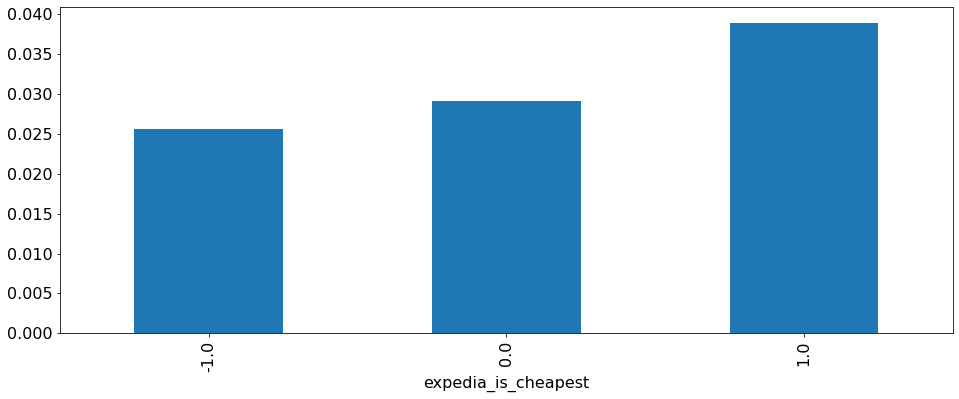

In [18]:
# Best aggregation for comp rates: min (i.e. Expedia is the cheapest
df.groupby('expedia_is_cheapest')['booking_bool'].mean().plot.bar()

In [19]:
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

## Replace categorical columns with ordinal columns based on price_per_day

calculate per each split

#### replace prop_country_id

In [20]:
avg_price = df.groupby('prop_country_id')['price_per_day'].mean()
avg_price = pd.DataFrame(avg_price)
avg_price = avg_price.sort_values('price_per_day').reset_index().reset_index().set_index('prop_country_id').sort_index()
avg_price = avg_price.drop('price_per_day', axis=1).rename(columns={'index': 'ordinal_prop_country_id'})

avg_price.head()

,ordinal_prop_country_id
prop_country_id,
2,59
4,71
9,56
10,2
11,62


In [21]:
df = pd.merge(df, avg_price['ordinal_prop_country_id'], right_index=True, left_on = 'prop_country_id', how='left')

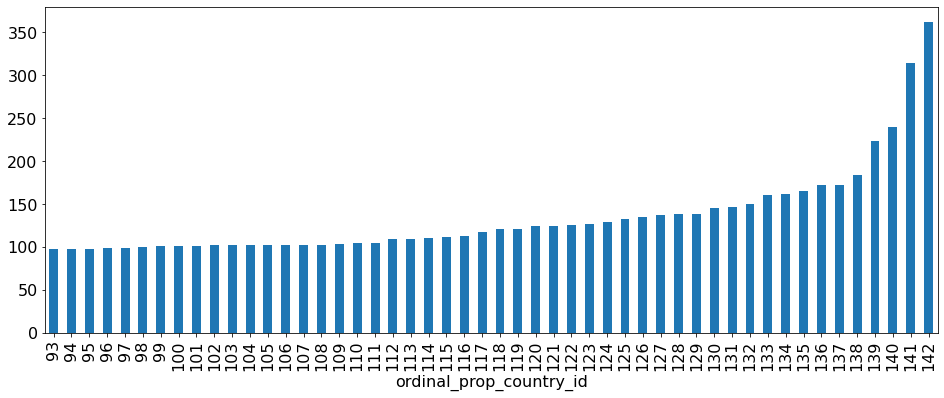

In [22]:
df.groupby('ordinal_prop_country_id')['price_per_day'].mean()[-50:].plot.bar();

#### replace site_id

In [23]:
avg_price = df.groupby('site_id')['price_per_day'].mean()
avg_price = pd.DataFrame(avg_price)
avg_price = avg_price.sort_values('price_per_day').reset_index().reset_index().set_index('site_id').sort_index()
avg_price = avg_price.drop('price_per_day', axis=1).rename(columns={'index': 'ordinal_site_id'})

avg_price.head()

,ordinal_site_id
site_id,
1,12
2,29
3,3
4,6
5,25


In [24]:
df = pd.merge(df, avg_price['ordinal_site_id'], right_index=True, left_on = 'site_id', how='left')

#### replace visitor_location_country_id

In [25]:
avg_price = df.groupby('visitor_location_country_id')['price_per_day'].mean()
avg_price = pd.DataFrame(avg_price)
avg_price = avg_price.sort_values('price_per_day').reset_index().reset_index().set_index('visitor_location_country_id').sort_index()
avg_price = avg_price.drop('price_per_day', axis=1).rename(columns={'index': 'ordinal_visitor_location_country_id'})

avg_price.head()

,ordinal_visitor_location_country_id
visitor_location_country_id,
1,14
2,128
3,21
4,91
5,150


In [26]:
df = pd.merge(df, avg_price['ordinal_visitor_location_country_id'], right_index=True, left_on = 'visitor_location_country_id', how='left')


#### replace prop_id

In [27]:
avg_price = df.groupby('prop_id')['price_per_day'].mean()
avg_price = pd.DataFrame(avg_price)
avg_price = avg_price.sort_values('price_per_day').reset_index().reset_index().set_index('prop_id').sort_index()
avg_price = avg_price.drop('price_per_day', axis=1).rename(columns={'index': 'ordinal_prop_id'})

avg_price.head()

,ordinal_prop_id
prop_id,
1,27998
3,31248
5,46543
11,28987
12,8492


In [28]:
df = pd.merge(df, avg_price['ordinal_prop_id'], right_index=True, left_on = 'prop_id', how='left')


#### replace srch_destination_id

In [29]:
avg_price = df.groupby('srch_destination_id')['price_per_day'].mean()
avg_price = pd.DataFrame(avg_price)
avg_price = avg_price.sort_values('price_per_day').reset_index().reset_index().set_index('srch_destination_id').sort_index()
avg_price = avg_price.drop('price_per_day', axis=1).rename(columns={'index': 'ordinal_srch_destination_id'})

avg_price.head()

,ordinal_srch_destination_id
srch_destination_id,
2,8765
3,2341
5,212
7,14314
8,11948


In [30]:
df = pd.merge(df, avg_price['ordinal_srch_destination_id'], right_index=True, left_on = 'srch_destination_id', how='left')

In [31]:
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,holiday,business_trip,price_per_day,price_per_trip,expedia_is_cheapest,ordinal_prop_country_id,ordinal_site_id,ordinal_visitor_location_country_id,ordinal_prop_id,ordinal_srch_destination_id
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,81437,3,4.0,...,0,False,138.400,138.40,0.0,84,24,30,38587,11354
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,114766,2,3.5,...,0,False,104.770,104.77,NaN,84,24,30,33995,11354
2,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,129278,3,3.5,...,0,False,80.000,160.00,NaN,84,25,122,38750,13029
3,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,134162,5,4.5,...,0,False,262.500,525.00,NaN,84,25,122,56118,13029
4,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,139893,2,3.0,...,0,False,64.500,129.00,NaN,84,25,122,34598,13029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496128,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,25223,4,4.0,...,0,True,72.510,145.02,0.0,104,19,122,29202,10117
496129,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,28943,4,3.5,...,0,True,72.510,145.02,0.0,104,19,122,36197,10117
496130,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,52463,4,4.5,...,0,True,118.740,237.48,-1.0,104,19,122,52322,10117
496131,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,90665,4,4.5,...,0,True,106.575,213.15,0.0,104,19,122,50072,10117


### drop original: srch_id, site_id, visitor_location_country_id, prop_country_id, prop_id

In [32]:
#df.drop(['srch_id', 'site_id', 'visitor_location_country_id', 'prop_country_id', 'prop_id'], axis=1, inplace=True)
#df

## Estimating the quality of Hotels using target columns, only use on df train!
likeliness of click and book per hotel\
mean position of hotel

TODO: add srch_query_affinity_score

In [33]:
# count the occurences of hotels, no of searches the hotel occured in, except where random ordering was used
prop_id_count = pd.DataFrame(df[df['random_bool'] == 0].groupby('prop_id')['srch_id'].count()).rename(columns={'srch_id': 'occurences'})
prop_id_count

,occurences
prop_id,
1,5
3,5
5,2
11,8
12,2
...,...
140809,12
140810,1
140815,9


In [34]:
#calculate mean per prop_id, without randomly ordered searches
prop_id_quality = df.groupby('prop_id')['click_bool', 'booking_bool', 'index_per_srch_id'].mean()
prop_id_quality = df[df['random_bool'] == 0].groupby('prop_id')['click_bool', 'booking_bool', 'index_per_srch_id'].mean()
prop_id_quality.rename(columns={'click_bool': 'mean_click_bool_per_prop_id', 'booking_bool': 'mean_booking_bool_per_prop_id', 'index_per_srch_id': 'mean_position_per_prop_id'}, inplace=True)
prop_id_quality



/var/folders/qd/2v2_mp9x4vq3mdm35p6mbz6h0000gn/T/ipykernel_45757/1766624569.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prop_id_quality = df.groupby('prop_id')['click_bool', 'booking_bool', 'index_per_srch_id'].mean()
/var/folders/qd/2v2_mp9x4vq3mdm35p6mbz6h0000gn/T/ipykernel_45757/1766624569.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  prop_id_quality = df[df['random_bool'] == 0].groupby('prop_id')['click_bool', 'booking_bool', 'index_per_srch_id'].mean()


,mean_click_bool_per_prop_id,mean_booking_bool_per_prop_id,mean_position_per_prop_id
prop_id,,,
1,0.000000,0.000000,1.600000
3,0.000000,0.000000,1.400000
5,0.000000,0.000000,1.000000
11,0.000000,0.000000,1.625000
12,0.000000,0.000000,0.000000
...,...,...,...
140809,0.083333,0.083333,1.000000
140810,0.000000,0.000000,2.000000
140815,0.000000,0.000000,2.222222


In [35]:
# Hotels shown often do not seem to be of higher quality, the percentage of click and bookings is the same as other
# mean position does not change either

min_occurences = 10
print('shown frequently:\n',prop_id_quality[prop_id_count['occurences'] >= min_occurences].mean())
print('\nshown infrequently:\n',prop_id_quality[prop_id_count['occurences'] < min_occurences].mean())


shown frequently:
 mean_click_bool_per_prop_id      0.043117
mean_booking_bool_per_prop_id    0.036586
mean_position_per_prop_id        1.404311
dtype: float64

shown infrequently:
 mean_click_bool_per_prop_id      0.044506
mean_booking_bool_per_prop_id    0.036920
mean_position_per_prop_id        1.102644
dtype: float64


In [36]:
# thus use mean of all hotels for infrequent ones
mean_values = df[['click_bool', 'booking_bool', 'index_per_srch_id']].mean()

prop_id_quality.loc[prop_id_count['occurences'] < min_occurences, 
                    ['mean_click_bool_per_prop_id', 'mean_booking_bool_per_prop_id', 'mean_position_per_prop_id']] = list(mean_values)
prop_id_quality.loc[prop_id_count['occurences'] < min_occurences]
prop_id_quality


,mean_click_bool_per_prop_id,mean_booking_bool_per_prop_id,mean_position_per_prop_id
prop_id,,,
1,0.044815,0.027969,1.294335
3,0.044815,0.027969,1.294335
5,0.044815,0.027969,1.294335
11,0.044815,0.027969,1.294335
12,0.044815,0.027969,1.294335
...,...,...,...
140809,0.083333,0.083333,1.000000
140810,0.044815,0.027969,1.294335
140815,0.044815,0.027969,1.294335


In [37]:
#look for prop_id that only apppeared in randomly ordered searches and thus are missing from prop_id_quality
missing = df[~df['prop_id'].isin(prop_id_quality.index)]['prop_id']
missing = pd.DataFrame(missing).set_index('prop_id')

# fill missing prop_id with mean
prop_id_quality = pd.concat([prop_id_quality, missing])
prop_id_quality.loc[missing.index] = list(mean_values)
prop_id_quality

,mean_click_bool_per_prop_id,mean_booking_bool_per_prop_id,mean_position_per_prop_id
prop_id,,,
1,0.044815,0.027969,1.294335
3,0.044815,0.027969,1.294335
5,0.044815,0.027969,1.294335
11,0.044815,0.027969,1.294335
12,0.044815,0.027969,1.294335
...,...,...,...
72034,0.044815,0.027969,1.294335
2327,0.044815,0.027969,1.294335
31431,0.044815,0.027969,1.294335


In [38]:
# merge prop_id_quality with df
df = pd.merge(df, prop_id_quality, right_index=True, left_on = 'prop_id', how='left')

## Average numeric features over:
srch_id\
visitor_location_country_id\
prop_id\
srch_destination_id\
prop_starrating

In [39]:
# add the average/min/max of these features over some column 
# for example: calc avg of these columns for every search_id
numeric_features = ['visitor_hist_starrating', 'visitor_hist_adr_usd',
       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_query_affinity_score', 'orig_destination_distance']

In [45]:
# groupy by these columns
groupby_columns = ['srch_id', 'visitor_location_country_id', 'prop_id', 'prop_starrating', 'srch_destination_id']
df_groupbys = []

# first create aggreagted all dataframes over specified columns, adjust column names
for split_col in groupby_columns:
    # aggregate mean
    df_groupby_mean = df.groupby(split_col)[numeric_features].mean()
    new_colnames = []
    for col in numeric_features:
        new_colnames.append('mean_' + col + '_over_' + split_col)
    df_groupby_mean.columns = new_colnames
    #df_groupbys.append(df_groupby_mean)
    
    # aggregate min
    df_groupby_min = df.groupby(split_col)[numeric_features].min()
    new_colnames = []
    for col in numeric_features:
        new_colnames.append('min_' + col + '_over_' + split_col)
    df_groupby_min.columns = new_colnames
    #df_groupbys.append(df_groupby_min)
    
    # aggregate max
    df_groupby_max = df.groupby(split_col)[numeric_features].max()
    new_colnames = []
    for col in numeric_features:
        new_colnames.append('max_' + col + '_over_' + split_col)
    df_groupby_max.columns = new_colnames
    #df_groupbys.append(df_groupby_max)
    df_groupbys.append(pd.concat([df_groupby_mean, df_groupby_min, df_groupby_max], axis=1))
    
# merge oridinal df with the aggregated dataframes

for col, df_groupby in zip(groupby_columns, df_groupbys):
    df = pd.merge(df, df_groupby, right_index=True, left_on = col, how='left')

In [46]:
# normed difference between value and mean/min/max aggregated values
# for example: (value - mean(aggregated values)) / mean(aggregated values)
for split_col in groupby_columns:
    for col1 in numeric_features:
        #diff to mean
        col2 = 'mean_' + col1 + '_over_' + split_col
        df['diff_to_' + col2] = (df[col1] - df[col2]) / df[col2]
        
        #diff to min
        col2 = 'min_' + col1 + '_over_' + split_col
        df['diff_to_' + col2] = (df[col1] - df[col2]) / df[col2]
        
        #diff to max
        col2 = 'max_' + col1 + '_over_' + split_col
        df['diff_to_' + col2] = (df[col1] - df[col2]) / df[col2]

/var/folders/qd/2v2_mp9x4vq3mdm35p6mbz6h0000gn/T/ipykernel_45757/1347481713.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['diff_to_' + col2] = (df[col1] - df[col2]) / df[col2]
/var/folders/qd/2v2_mp9x4vq3mdm35p6mbz6h0000gn/T/ipykernel_45757/1347481713.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['diff_to_' + col2] = (df[col1] - df[col2]) / df[col2]
/var/folders/qd/2v2_mp9x4vq3mdm35p6mbz6h0000gn/T/ipykernel_45757/1347481713.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [47]:
df

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,diff_to_max_srch_children_count_over_srch_destination_id,diff_to_mean_srch_room_count_over_srch_destination_id,diff_to_min_srch_room_count_over_srch_destination_id,diff_to_max_srch_room_count_over_srch_destination_id,diff_to_mean_srch_query_affinity_score_over_srch_destination_id,diff_to_min_srch_query_affinity_score_over_srch_destination_id,diff_to_max_srch_query_affinity_score_over_srch_destination_id,diff_to_mean_orig_destination_distance_over_srch_destination_id,diff_to_min_orig_destination_distance_over_srch_destination_id,diff_to_max_orig_destination_distance_over_srch_destination_id
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,81437,3,4.0,...,-1.0,-0.132165,0.0,-0.875,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,114766,2,3.5,...,-1.0,-0.132165,0.0,-0.875,NaN,NaN,NaN,NaN,NaN,NaN
2,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,129278,3,3.5,...,-1.0,-0.130273,0.0,-0.800,NaN,NaN,NaN,-0.888911,1588.200000,-0.974463
3,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,134162,5,4.5,...,-1.0,-0.130273,0.0,-0.800,NaN,NaN,NaN,-0.888930,1587.933333,-0.974467
4,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,139893,2,3.0,...,-1.0,-0.130273,0.0,-0.800,NaN,NaN,NaN,-0.889955,1573.266667,-0.974703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496128,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,25223,4,4.0,...,-1.0,-0.117357,0.0,-0.875,NaN,NaN,NaN,-0.411013,4117.625000,-0.913880
496129,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,28943,4,3.5,...,-1.0,-0.117357,0.0,-0.875,NaN,NaN,NaN,-0.410173,4123.500000,-0.913757
496130,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,52463,4,4.5,...,-1.0,-0.117357,0.0,-0.875,NaN,NaN,NaN,-0.411549,4113.875000,-0.913958
496131,332784,2013-06-18 14:35:24,24,219,NaN,NaN,100,90665,4,4.5,...,-1.0,-0.117357,0.0,-0.875,NaN,NaN,NaN,-0.412407,4107.875000,-0.914083


In [ ]:
#TODO
#calculate diff between price_usd and gross_bookings_usd